# H3 Podcast Views Analysis

Below is a brief look into public video metadata for H3 Podacst episodes. I accessed data from the Youtube Data API and focused is on episodes released in 2020 onwards.

# Data Import and Wrangling

In [49]:
# import libaries
import io
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
from google.colab import files

# upload csv
uploaded = files.upload()

# read csv
h3 = pd.read_csv(io.BytesIO(uploaded['h3VideosUpdated.csv']))

# remove first column
h3.drop(['Unnamed: 0'],axis=1,inplace=True)

# rename columns
h3.columns = ['id','published_datetime','name','description','tags',
              'duration','start_scheduled','start_actual',
              'view_count','favorite_count','like_count','comment_count']

# convert datetime_published, start_scheduled, start_scheduled
h3['published_datetime'] = pd.to_datetime(h3['published_datetime'],format='%Y-%m-%dT%H:%M:%SZ')
h3['start_scheduled'] = pd.to_datetime(h3['start_scheduled'],format='%Y-%m-%dT%H:%M:%SZ')
h3['start_actual'] = pd.to_datetime(h3['start_actual'],format='%Y-%m-%dT%H:%M:%SZ')

# convert duration
h3['duration'] = pd.to_timedelta(h3['duration'])

# filter out shorts
h3 = h3[h3['duration'] > '00:20:00']

# filter out videos before 2020
h3 = h3[h3['published_datetime']>'2020']

# reset index
h3.reset_index(drop=True,inplace=True)

# categorise by series
h3['series'] = np.where(h3.name.str.contains('After Dark|Afterdark'),'After Dark',
                        np.where(h3.name.str.contains('H3TV'),'H3TV',
                                 np.where(h3.name.str.contains('H3 Podcast'),'H3 Podcast',
                                          np.where(h3.name.str.contains('Off The Rails|OTR'),'Off The Rails',
                                                   np.where(h3.name.str.contains('Content Court'),'Content Court',
                                                            np.where(h3.name.str.contains('Leftovers'),'Leftovers',
                                                                     np.where(h3.name.str.contains('Frenemies'),'Frenemies',
                                                                              np.where(h3.name.str.contains('Families'),'Families',
                                                                                       'Other'))))))))
# fix miscategorised videos
h3.at[7,'series']='Off The Rails'
h3.at[40,'series']='After Dark'
h3.at[95,'series']='Off The Rails'
h3.at[126,'series']='Off The Rails'
h3.at[228,'series']='Families'

Saving h3VideosUpdated.csv to h3VideosUpdated (2).csv


# Top Episodes by Views
* Episodes with the most views tend to have titles mentioning popular internet celebrities.

In [6]:
h3.sort_values(['series','view_count'],ascending=False).groupby('series').head(3)[['series','name','view_count']]

,series,name,view_count
233,Other,I'm so angry,1772927
139,Other,Surprise Reunion For 2nd Annual Steamies,1523925
330,Other,Hila The Gamer Girl Destroys Us In Among Us,795994
206,Off The Rails,I'm Done With Trisha Paytas - Off The Rails #8,4203544
224,Off The Rails,Trisha’s Apology & Ace Family Scam - Off The R...,2597681
147,Off The Rails,Soundbite Of The Year Tournament 2021 - Off Th...,2251975
191,Leftovers,And The New Host Is... Leftovers #1,2044987
183,Leftovers,We Have Our First Heated Debate - Leftovers #3,1782889
87,Leftovers,Ben Shapiro & The Daily Wire Are Hateful Littl...,1665600
148,H3TV,The Wedding... - H3TV #20,2426567


# Average Views by Month-Year
Average views peaked in March 2021 and have been trending down since.


[Text(0, 0.5, 'Views Count (Millions)'), Text(0.5, 0, 'Month Year')]

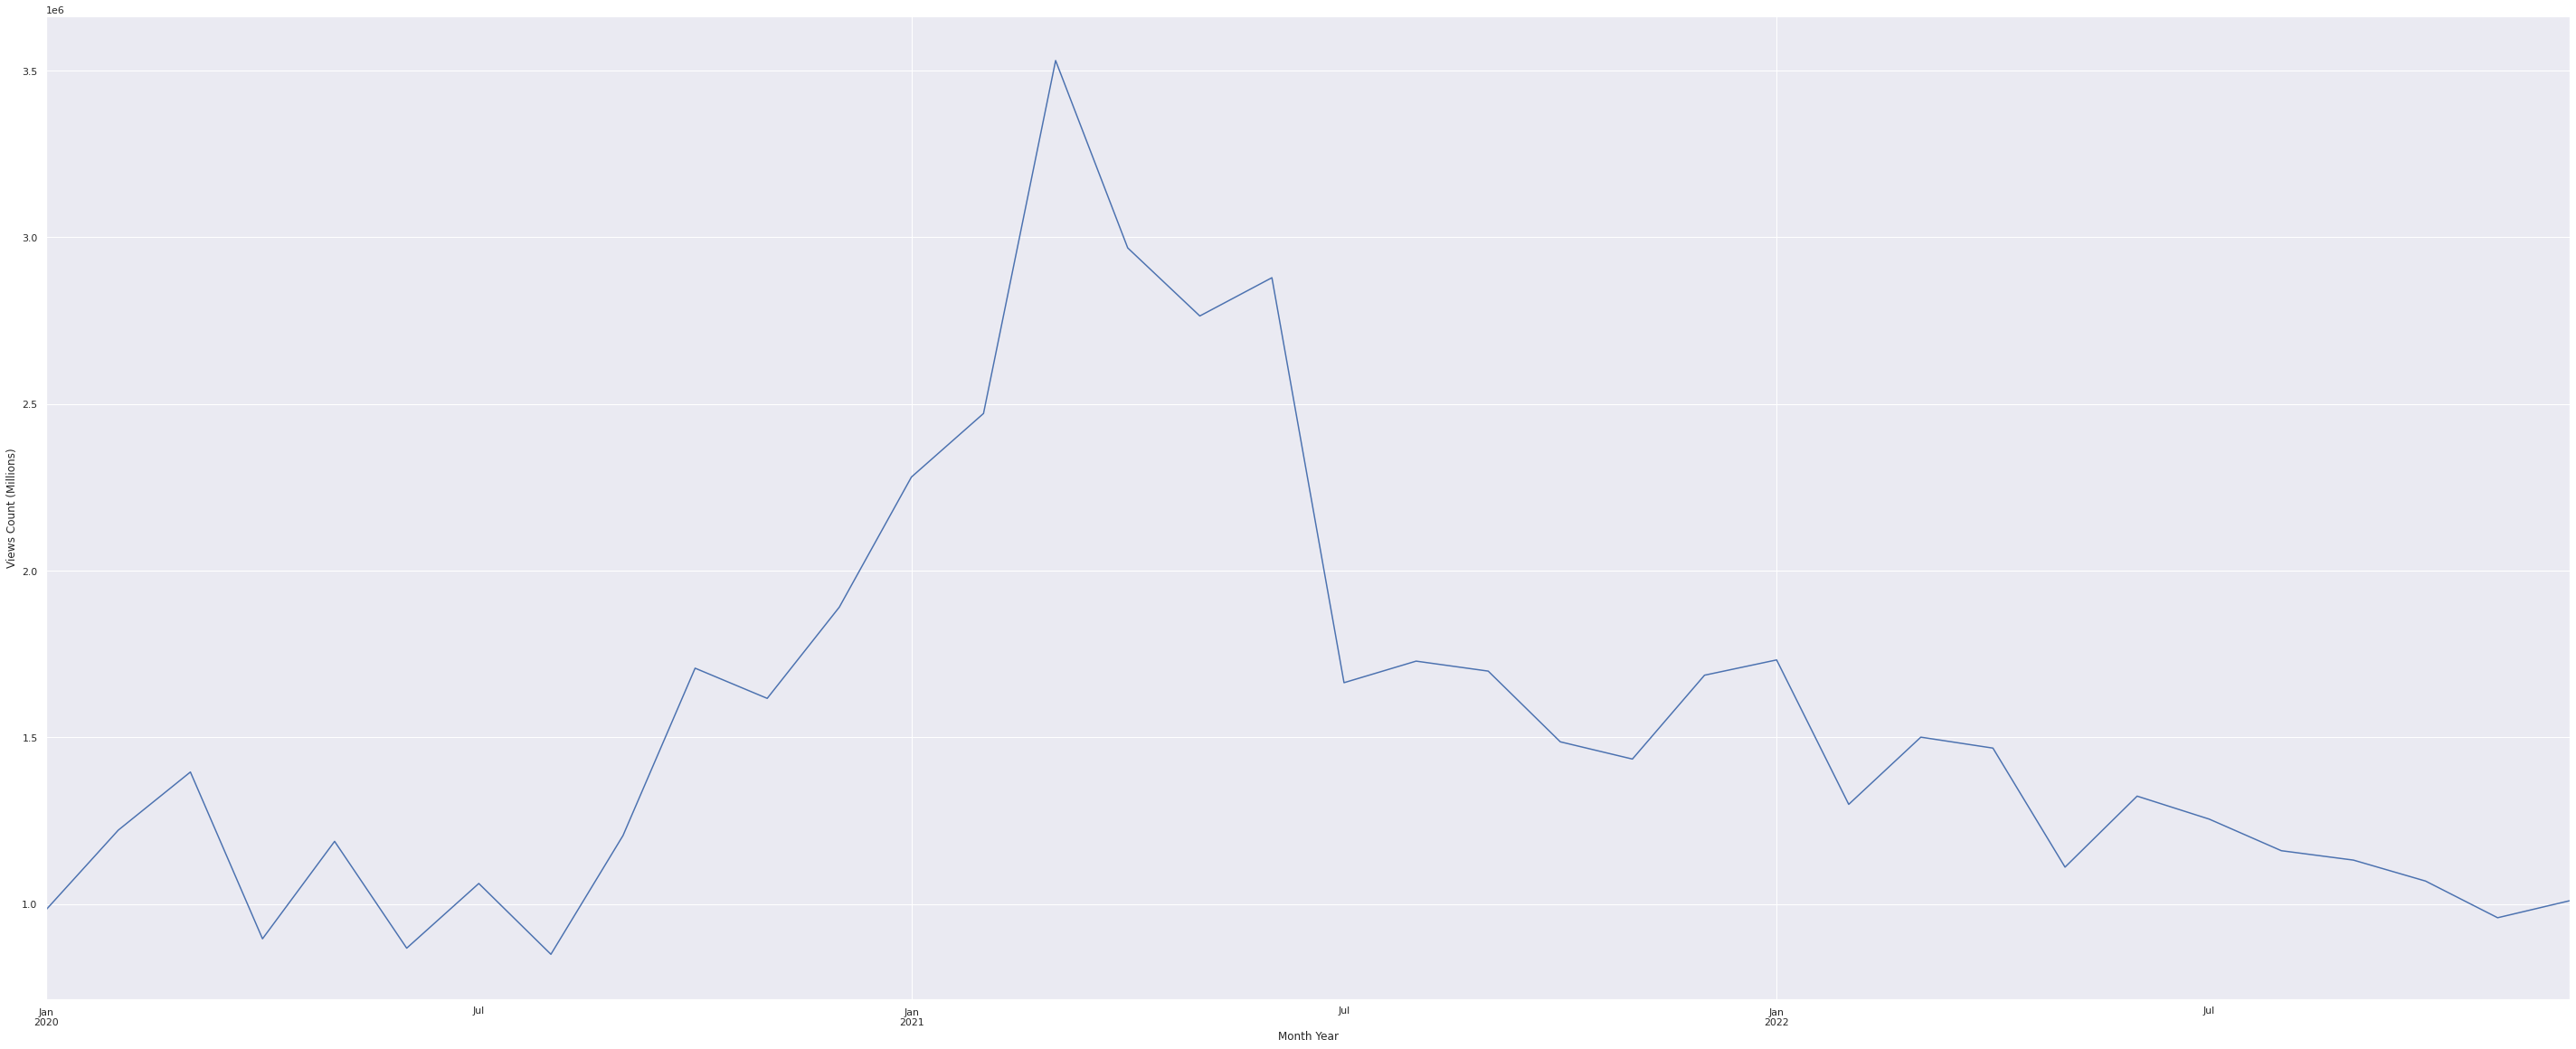

In [45]:
h3['published_my'] = h3['published_datetime'].dt.to_period('M')
plot = h3.groupby(['published_my'])['view_count'].mean().plot(kind='line',figsize=(50,20))
plot.set(xlabel='Month Year',ylabel='Views Count (Millions)')

# Likes to Views Ratio
* Episodes average a 2.71% in likes to views ratio, which is slightly below the Youtube average.

In [11]:
h3['like_view_ratio'] = h3['like_count'] / h3['view_count'] * 100
h3['like_view_ratio'].describe()

count    400.000000
mean       2.710017
std        0.776304
min        1.148945
25%        2.221602
50%        2.567208
75%        2.992002
max        6.699357
Name: like_view_ratio, dtype: float64

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Likes to Views Ratio (Percentage)')]

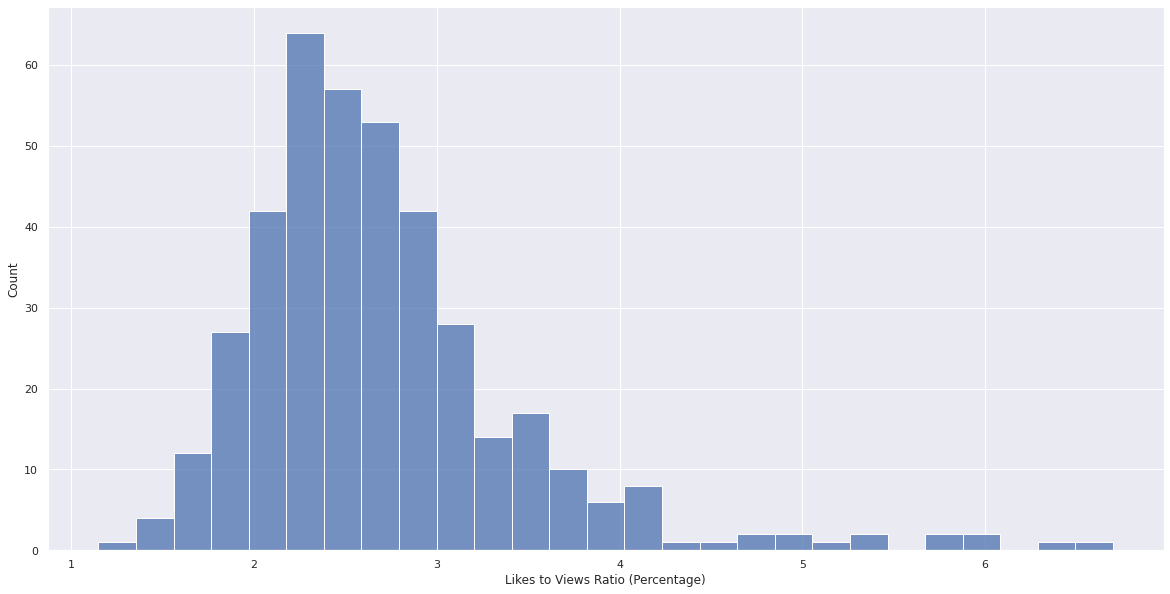

In [13]:
plot = sns.histplot(data=h3,x='like_view_ratio')
plot.set(xlabel='Likes to Views Ratio (Percentage)',ylabel='Count')

[Text(0, 0.5, 'Like Count'), Text(0.5, 0, 'View Count (Millions)')]

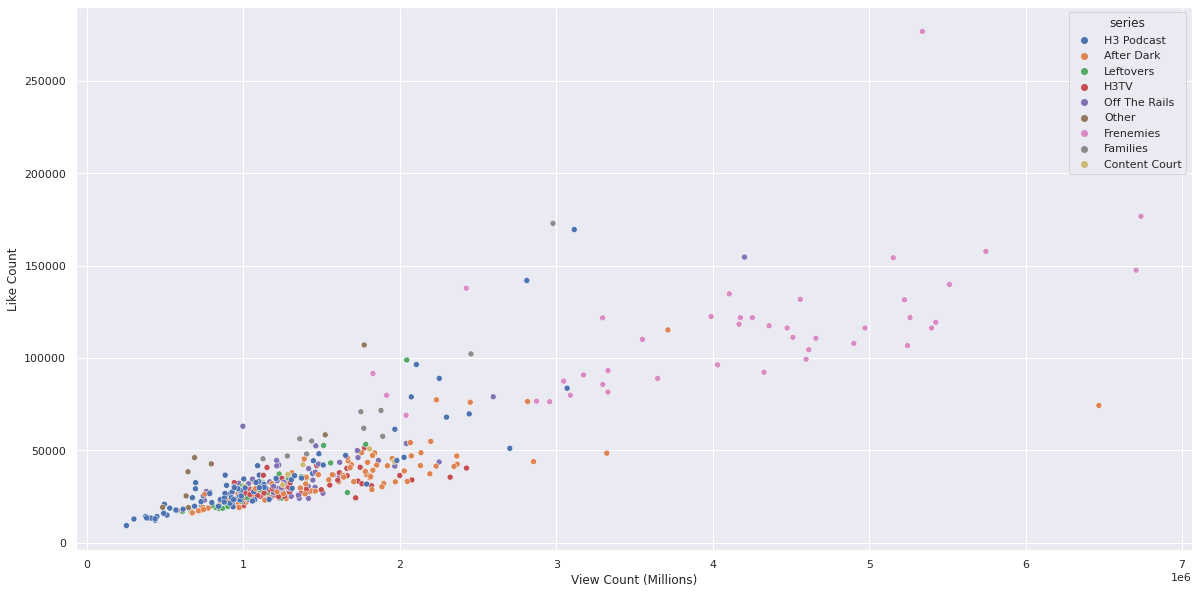

In [19]:
sns.set(rc={'figure.figsize':(20,10)})
plot = sns.scatterplot(data=h3,
                       x='view_count',
                       y='like_count',
                       hue='series')
plot.set(xlabel='View Count (Millions)',ylabel='Like Count')

# Top Series

### Total Views by Series
Despite having fewer episodes, Frenemies achieved more total views than After Dark, Off the Rails, and H3 Podcast.

(-1.25, 1.25, -1.25, 1.25)

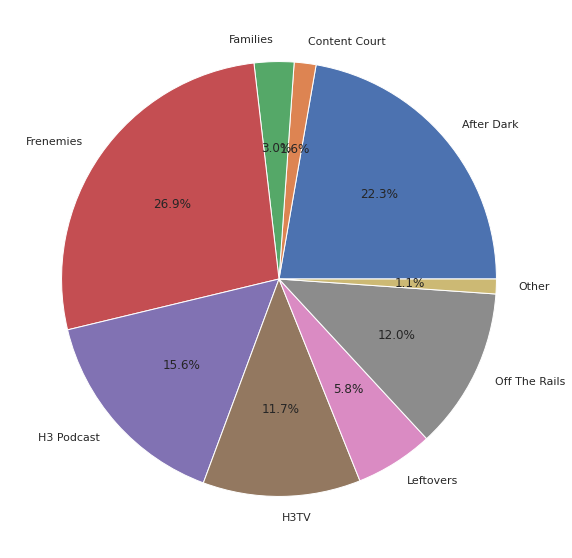

In [24]:
plot = h3.groupby(['series'])['view_count'].sum().plot(kind='pie',autopct='%1.1f%%',figsize=(10,10))
plt.axis('off')

### Average Views by Series
Frenemies, After Dark, and Families all average over 1.5 million in views.

[Text(0, 0.5, 'Series'), Text(0.5, 0, 'Average Views Count (Millions)')]

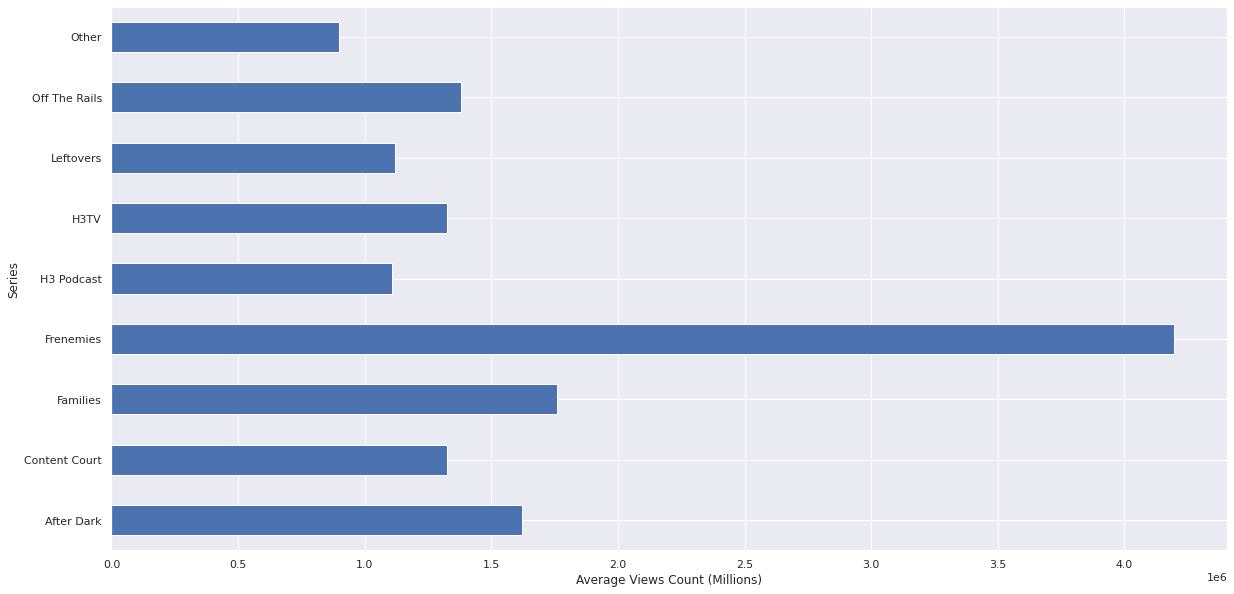

In [29]:
plot = h3.groupby(['series'])['view_count'].mean().plot(kind='barh',figsize=(20,10))
plot.set(xlabel='Average Views Count (Millions)',ylabel='Series')

### Distribution of Views by Series
Frenemies and After Dark have the largest spread in views. Leftovers have the smallest, indicating a smaller but more consistent/loyal audience. 

[Text(0, 0.5, 'Series'), Text(0.5, 0, 'Views Count')]

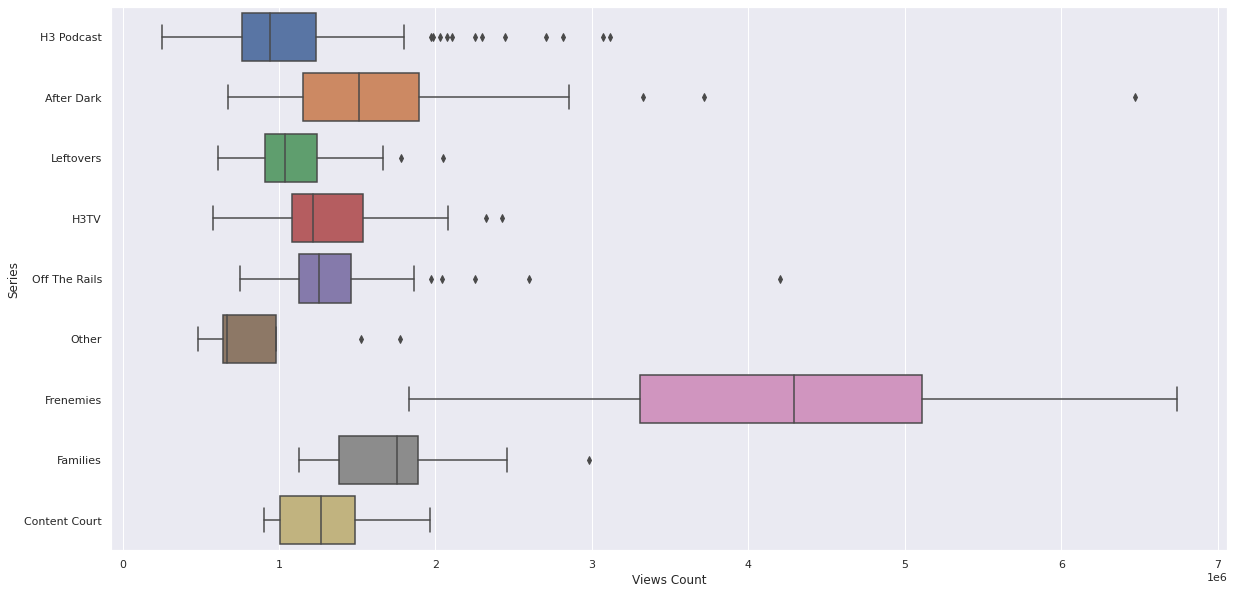

In [38]:
plt.figure(figsize=(20,10))
plot = sns.boxplot(data=h3,x='view_count',y='series')
plot.set(xlabel='Views Count',ylabel='Series')

Notes:
* Silent Libary videos are under 'Off The Rails'
* Frenemies Vlogs are under 'Frenemies'
* Off the Rail videos published before the official 'Off The Rails #1' are under 'H3 Podcast'

# Words in Title (Excluding Series Name and Stop Words) 

### Most common words in all titles

In [62]:
#nltk.download('stopwords')
stop = stopwords.words('english')
stop.append('&')

In [63]:
h3['title'] = h3['name'].str.rsplit('-',1,expand=True)[0]
h3['title_no_stopwords'] = h3['title'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
Counter(' '.join(h3['title_no_stopwords']).split()).most_common(20)

[('ethan', 33),
 ('david', 28),
 ('trisha', 28),
 ('dobrik', 21),
 ('h3', 20),
 ('james', 19),
 ('family', 17),
 ('calls', 17),
 ('dark', 17),
 ('charles', 14),
 ('new', 14),
 ('got', 13),
 ('elon', 12),
 ('andrew', 11),
 ('vs', 11),
 ('ace', 11),
 ('jeff', 10),
 ('paul', 9),
 ('banned', 8),
 ('musk', 8)]

### Most popular words in all non-frenemies titles

In [64]:
h3_nofrenemies = h3[h3['series']!='Frenemies']
h3_top = h3_nofrenemies.nlargest(179,'view_count')
Counter(' '.join(h3_top['title_no_stopwords']).split()).most_common(20)

[('james', 16),
 ('david', 16),
 ('dobrik', 13),
 ('charles', 12),
 ('family', 12),
 ('trisha', 10),
 ('ace', 10),
 ('ethan', 9),
 ('calls', 9),
 ('jeff', 7),
 ('paytas', 6),
 ('new', 6),
 ('mom', 6),
 ('jordan', 6),
 ('sued', 5),
 ('vs', 5),
 ('shane', 5),
 ('youtube', 5),
 ("i'm", 4),
 ('real', 4)]

### Least popular words in all non-frenemies titles

In [65]:
h3_nofrenemies = h3[h3['series']!='Frenemies']
h3_bottom = h3_nofrenemies.nsmallest(179,'view_count')
Counter(' '.join(h3_bottom['title_no_stopwords']).split()).most_common(20)

[('h3', 17),
 ('dark', 15),
 ('ethan', 13),
 ('elon', 9),
 ('got', 9),
 ('calls', 8),
 ('andrew', 7),
 ('banned', 6),
 ('trump', 6),
 ('paul', 6),
 ('new', 6),
 ('us', 5),
 ('jake', 5),
 ('musk', 5),
 ('tim', 4),
 ('keemstar', 4),
 ('go', 4),
 ('family', 4),
 ('lee', 4),
 ('david', 4)]

# Tardiness

In [ ]:
h3_streams = h3[h3['start_scheduled'].notnull()]
h3_streams = h3_streams[h3['series']!='Content Court']
h3_streams = h3_streams[h3['series']!='Frenemies']
h3_streams['start_dif'] = (h3_streams['start_actual'] - h3_streams['start_scheduled']).dt.total_seconds()/60
h3_streams['tardy'] = h3_streams['start_dif'] > 0

[Text(0, 0.5, 'Series'), Text(0.5, 0, 'Average Minutes Late')]

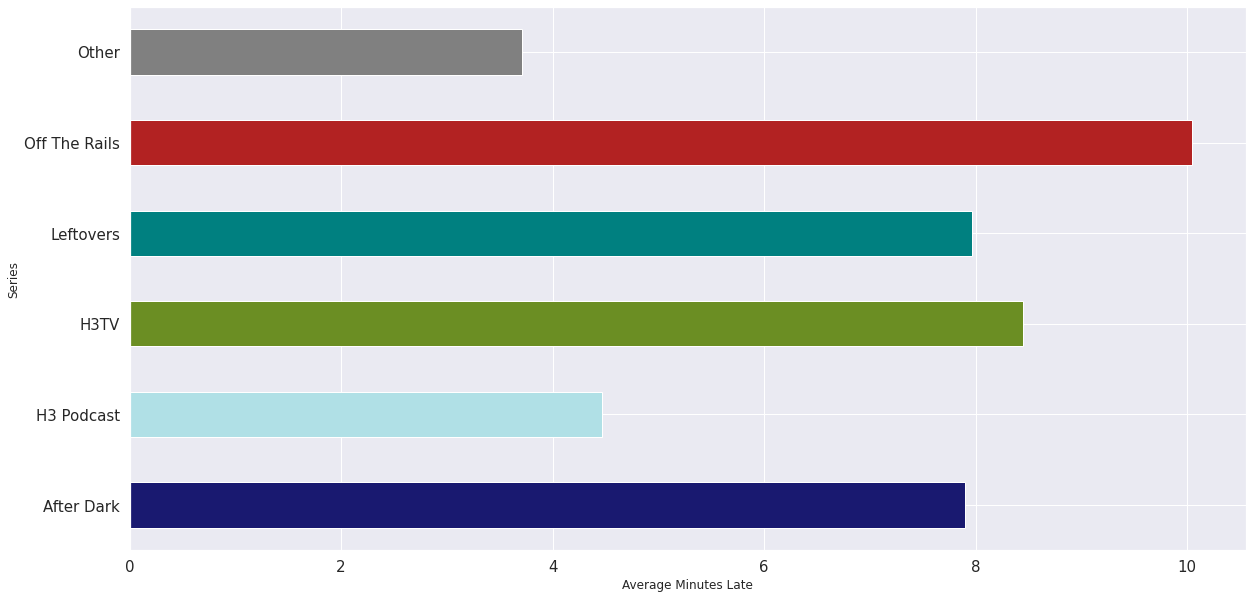

In [75]:
c = ['midnightblue','powderblue','olivedrab','teal','firebrick','grey']
plot = h3_streams.groupby(['series'])['start_dif'].mean().plot(kind='barh',color=c,
                                                               fontsize=15,figsize=(20,10))
plot.set(xlabel='Average Minutes Late',ylabel='Series')

# Further Steps

Youtube analytics is meaningful because uncovered insights can identify what drives engagement, quantify value to potential sponsors, etc.

# Export Data

In [7]:
h3.to_csv('h3Videos_processed.csv')
files.download('h3Videos_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>